# Atividade 1 : previsão de séries temporais

- Objeto de estudo: contratos futuros de commodities agrícolas
- Série escolhida: preço do milho futuro negociado na CBOT  


## Relatório Empírico

- Objeto de estudo: contratos futuros de commodities agrícolas
- Série escolhida: preço do milho futuro negociado na CBOT 
- Importancia: 
    - Brasil exportador de commodities 
    - Preços de commodities possuem grande impacto na economia Brasileira e global  (contexto inflacionário)
    - Apesar da série não ser de negociações na B3, os EUA abrigam o maior mercado financeiro do Mundo.
- Justficativas metodológicas :
    - Divisão de treino e teste
    - ARIMA 
    - Rede Neural
    - XGBoost



In [44]:
%load_ext autoreload
%autoreload 2

import ta
import datetime
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import pmdarima as pm
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import sklearn.metrics as metrics
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox


# codigos adaptados do livro Modern Time Series Forecasting with Python
from stationary_checks import  (check_heteroscedastisticity, check_seasonality, check_trend,check_unit_root)
from transformations import AutoStationaryTransformer 

#codigos prorpios
#from modeling_utils import train_test_split, get_kpis_summary ,check_arima_residuals , plot_acf_pcf
from modeling_utils import * 

warnings.filterwarnings("ignore")
get_ipython().run_line_magic("matplotlib", "inline")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Dados

[*DESCREVER*]

In [2]:


plt.style.use("fivethirtyeight")
# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

# Carrega a base
ticker = "ZC=F"
commodity = yf.download(ticker, "2002-01-01", "2023-05-01")
#commodity = yf.download(ticker, "2002-01-01", "2023-04-30",interval='1mo')


[*********************100%***********************]  1 of 1 completed


In [3]:
commodity.to_csv("ZCF-CBOT.csv")

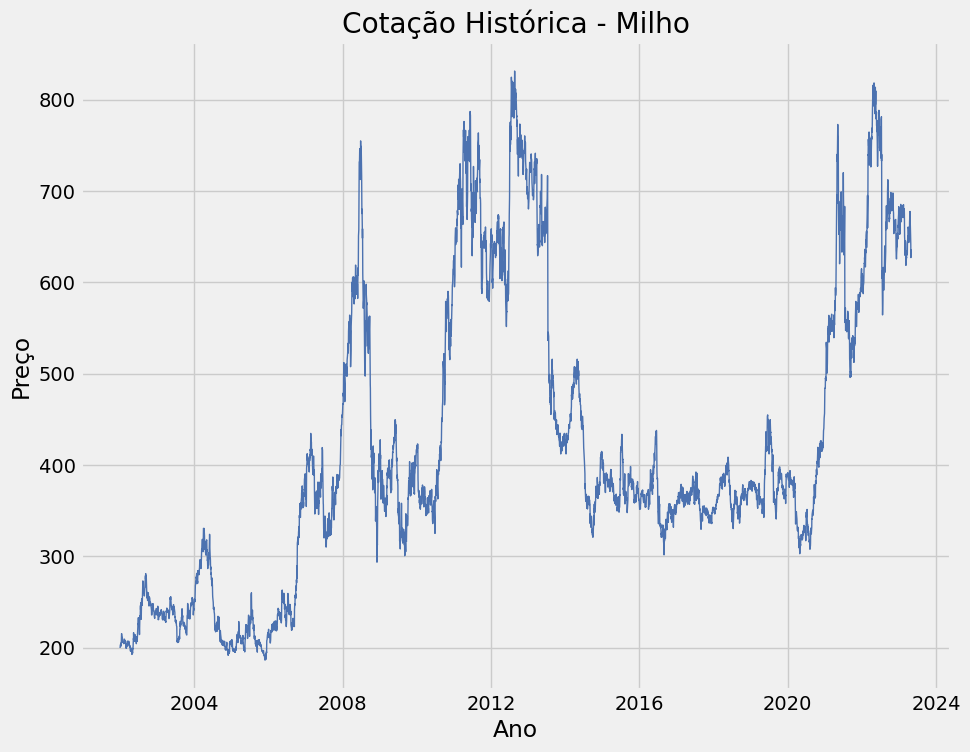

In [4]:

with plt.style.context("seaborn-deep"):
    plt.figure(figsize = (10,8))
    plt.plot(commodity["Adj Close"], linewidth = 1)
    plt.xlabel("Ano")
    plt.ylabel("Preço")
    plt.title("Cotação Histórica - Milho")

<AxesSubplot:xlabel='Date'>

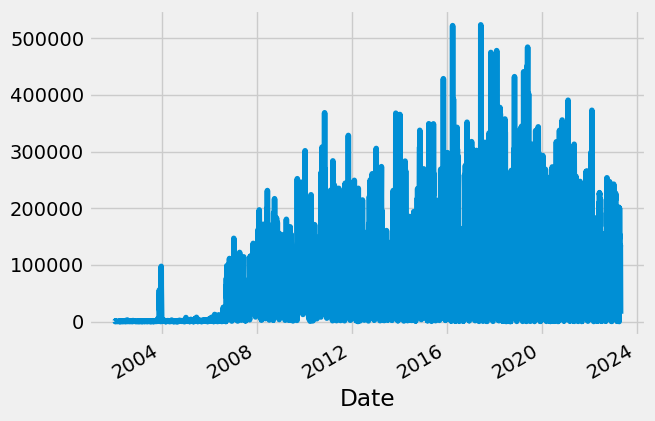

In [9]:
# Baixo volume no inicio da serie - aumento apenas em 2008
# estartegias nesse periodo seriam dificeis de serem implatadas 

commodity['Volume'].plot() 

In [10]:
commodity['return'] = commodity['Adj Close'].pct_change()
commodity.dropna(inplace=True)
commodity # dados OHLC

,Open,High,Low,Close,Adj Close,Volume,return
Date,,,,,,,
2002-01-03,202.00,202.00,202.00,202.00,202.00,4,0.012531
2002-01-04,202.50,202.50,202.50,202.50,202.50,4,0.002475
2002-01-07,203.50,203.50,203.50,203.50,203.50,4,0.004938
2002-01-08,204.00,204.00,204.00,204.00,204.00,4,0.002457
2002-01-09,202.50,202.50,202.50,202.50,202.50,4,-0.007353
...,...,...,...,...,...,...,...
2023-04-24,663.25,667.50,648.50,651.25,651.25,134977,-0.018093
2023-04-25,651.25,653.00,641.50,646.50,646.50,100633,-0.007294
2023-04-26,648.00,652.25,641.00,641.50,641.50,65293,-0.007734


In [11]:
commodity.describe()

,Open,High,Low,Close,Adj Close,Volume,return
count,5366.000000,5366.000000,5366.000000,5366.000000,5366.000000,5366.000000,5366.000000
mean,419.511135,424.426482,414.891493,419.615123,419.615123,90848.904025,0.000384
std,161.074133,163.863489,158.268865,161.081246,161.081246,83860.066278,0.018268
min,186.250000,187.000000,185.750000,186.250000,186.250000,0.000000,-0.235567
25%,325.000000,328.812500,321.250000,325.000000,325.000000,2493.000000,-0.009379
50%,374.000000,378.250000,370.125000,374.250000,374.250000,89314.500000,0.000000
75%,539.937500,547.937500,531.500000,539.187500,539.187500,147422.250000,0.009894
max,830.250000,843.750000,822.750000,831.250000,831.250000,523849.000000,0.136066


In [12]:
commodity.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
return       0
dtype: int64

# Metodologia


## Checks de propriedades estatísticas

### Preço diário

In [15]:
checks_stats(commodity['Adj Close'])

Unit root test:  
 
 ADF_Test(stationary=False, results=(-1.8679760944815682, 0.34727282591417913, 27, 5338, {'1%': -3.431575636457688, '5%': -2.8620816063293675, '10%': -2.567058296408215}, 38445.02687528429)) 
 
 --------------------------------------------------
Trend Test: 
 
 Kendall_Tau_Test(trend=True, direction='increasing', slope=0.3636386807295458, p_value=0.0, deterministic=False, deterministic_trend_results=ADF_deterministic_Trend_Test(deterministic_trend=False, adf_res=ADF_Test(stationary=False, results=(-1.8679760944815682, 0.34727282591417913, 27, 5338, {'1%': -3.431575636457688, '5%': -2.8620816063293675, '10%': -2.567058296408215}, 38445.02687528429)), adf_ct_res=ADF_Test(stationary=False, results=(-2.1508957663683015, 0.5175049307635619, 27, 5338, {'1%': -3.960466970831445, '5%': -3.411312797744702, '10%': -3.1275345140651067}, 38445.88031520993)))) 
 
 --------------------------------------------------
Seasonality Test:  
 
 Seasonality_Test(seasonal=False, seasonal_

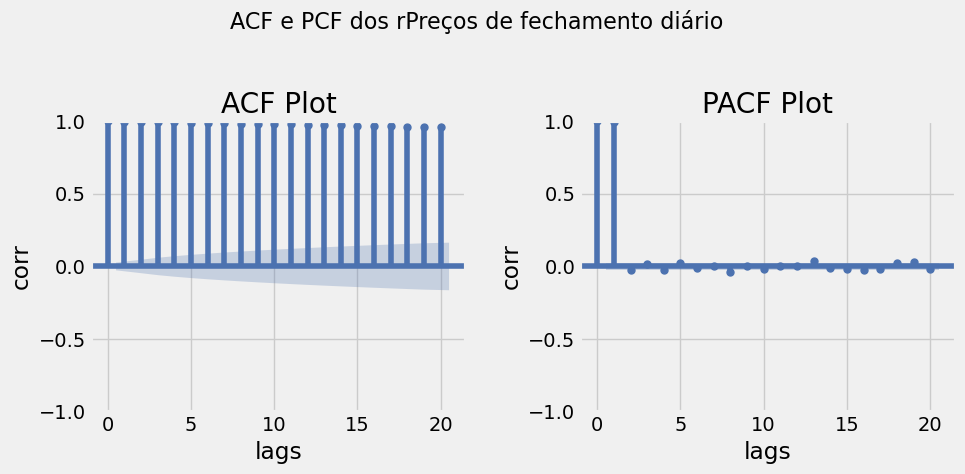

In [16]:
plot_acf_pcf(commodity['Adj Close'],fig_title="ACF e PCF dos rPreços de fechamento diário")

### Retorno diário

In [17]:
checks_stats(commodity['return'])

Unit root test:  
 
 ADF_Test(stationary=True, results=(-71.39179546482913, 0.0, 0, 5365, {'1%': -3.4315694653415583, '5%': -2.862078879884488, '10%': -2.567056845028658}, -27527.49496581636)) 
 
 --------------------------------------------------
Trend Test: 
 
 Kendall_Tau_Test(trend=False, direction='increasing', slope=0.010639990003827694, p_value=0.242693188900457, deterministic=False, deterministic_trend_results=ADF_deterministic_Trend_Test(deterministic_trend=False, adf_res=ADF_Test(stationary=True, results=(-71.39179546482913, 0.0, 0, 5365, {'1%': -3.4315694653415583, '5%': -2.862078879884488, '10%': -2.567056845028658}, -27527.49496581636)), adf_ct_res=ADF_Test(stationary=True, results=(-71.38605900840344, 0.0, 0, 5365, {'1%': -3.9604584256196307, '5%': -3.4113086553264065, '10%': -3.1275320749992916}, -27525.553900789593)))) 
 
 --------------------------------------------------
Seasonality Test:  
 
 Seasonality_Test(seasonal=True, seasonal_periods=3) 
 
 -------------------

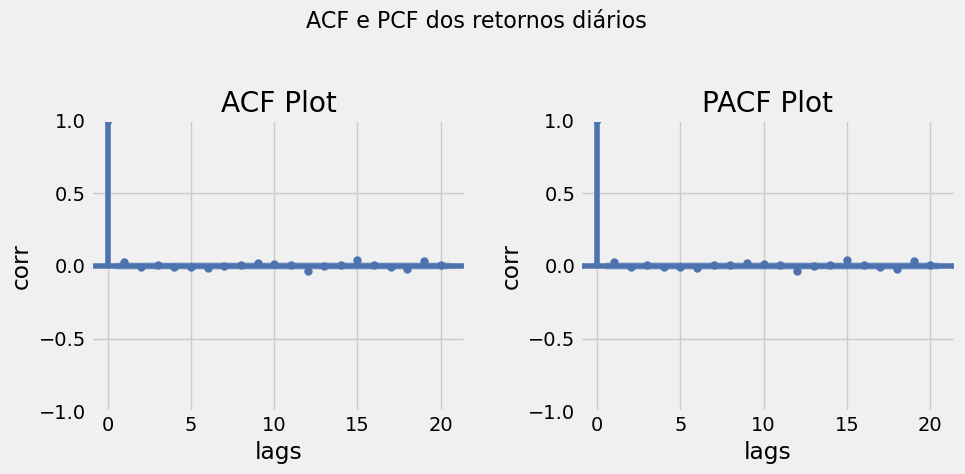

In [18]:
plot_acf_pcf(commodity['return'],fig_title="ACF e PCF dos retornos diários")

### Preços mensais

In [20]:
month_commodity = commodity.copy().asfreq("M",method='ffill')

In [21]:
checks_stats(month_commodity['Adj Close'])

Unit root test:  
 
 ADF_Test(stationary=False, results=(-1.591899912578697, 0.48766117879405096, 13, 241, {'1%': -3.4577787098622674, '5%': -2.873608704758507, '10%': -2.573201765981991}, 2478.3119123902893)) 
 
 --------------------------------------------------
Trend Test: 
 
 Kendall_Tau_Test(trend=True, direction='increasing', slope=0.36080822474529417, p_value=9.53952432839236e-18, deterministic=False, deterministic_trend_results=ADF_deterministic_Trend_Test(deterministic_trend=False, adf_res=ADF_Test(stationary=False, results=(-1.591899912578697, 0.48766117879405096, 13, 241, {'1%': -3.4577787098622674, '5%': -2.873608704758507, '10%': -2.573201765981991}, 2478.3119123902893)), adf_ct_res=ADF_Test(stationary=False, results=(-1.8484954892154453, 0.6809182353553195, 13, 241, {'1%': -3.9968337688702165, '5%': -3.4288662447936313, '10%': -3.1378478075975025}, 2479.4108135661213)))) 
 
 --------------------------------------------------
Seasonality Test:  
 
 Seasonality_Test(seasona

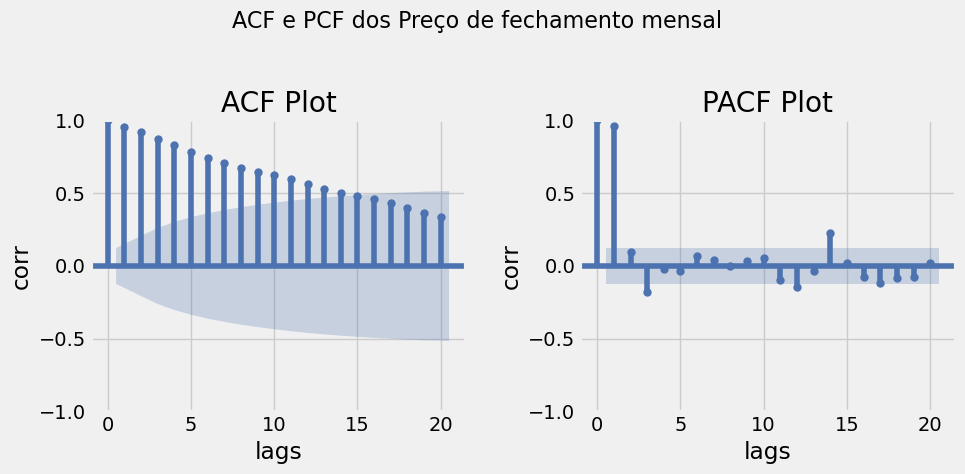

In [22]:
plot_acf_pcf(month_commodity['Adj Close'],fig_title="ACF e PCF dos Preço de fechamento mensal")

### Retornos mensais

In [23]:
checks_stats(month_commodity['Adj Close'].pct_change().dropna())

Unit root test:  
 
 ADF_Test(stationary=True, results=(-9.75169046640416, 7.984409372936552e-17, 1, 252, {'1%': -3.4565688966099373, '5%': -2.8730786194395455, '10%': -2.5729189953388762}, -469.5222329307303)) 
 
 --------------------------------------------------
Trend Test: 
 
 Kendall_Tau_Test(trend=False, direction='increasing', slope=3.1122591889452555e-05, p_value=0.9994104230812488, deterministic=False, deterministic_trend_results=ADF_deterministic_Trend_Test(deterministic_trend=False, adf_res=ADF_Test(stationary=True, results=(-9.75169046640416, 7.984409372936552e-17, 1, 252, {'1%': -3.4565688966099373, '5%': -2.8730786194395455, '10%': -2.5729189953388762}, -469.5222329307303)), adf_ct_res=ADF_Test(stationary=True, results=(-9.734545051890295, 8.546493724188268e-15, 1, 252, {'1%': -3.9951510399519887, '5%': -3.4280573478136107, '10%': -3.1373735230776614}, -467.5618531110299)))) 
 
 --------------------------------------------------
Seasonality Test:  
 
 Seasonality_Test(sea

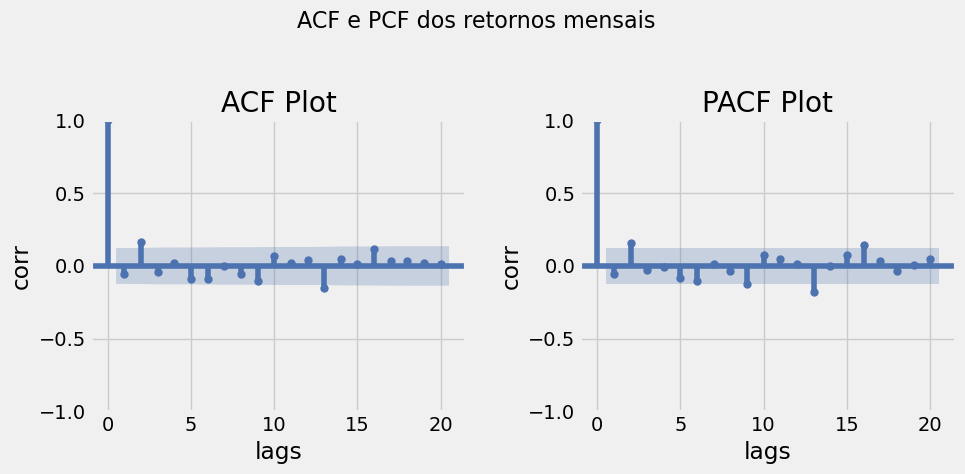

In [24]:
plot_acf_pcf(month_commodity['Adj Close'].pct_change().dropna(),fig_title="ACF e PCF dos retornos mensais")

## Modelos ARIMA

### ARIMA V1

- Dados diários
- Sem transformar 

In [26]:
commodity = commodity.reset_index()
commodity.head()

,Date,Open,High,Low,Close,Adj Close,Volume,return
0,2002-01-03,202.0,202.0,202.0,202.0,202.0,4,0.012531
1,2002-01-04,202.5,202.5,202.5,202.5,202.5,4,0.002475
2,2002-01-07,203.5,203.5,203.5,203.5,203.5,4,0.004938
3,2002-01-08,204.0,204.0,204.0,204.0,204.0,4,0.002457
4,2002-01-09,202.5,202.5,202.5,202.5,202.5,4,-0.007353


Train : start:2002-01-03 00:00:00 ---- end:2021-12-31 00:00:00
Test : start:2022-01-03 00:00:00 ---- end:2023-04-28 00:00:00
Tamanho treino:  5034
Tamanho teste:  332
(1, 1, 1)


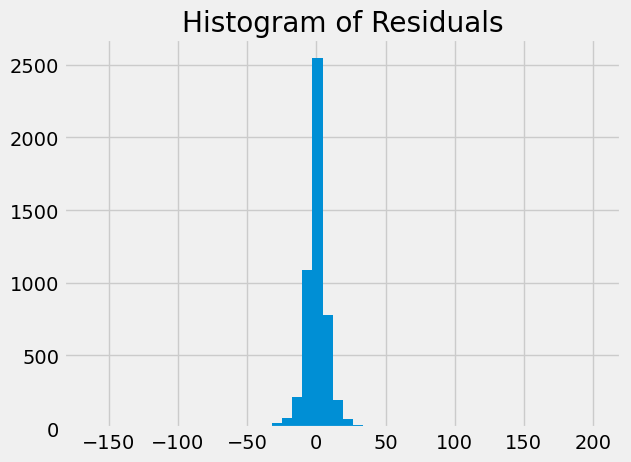

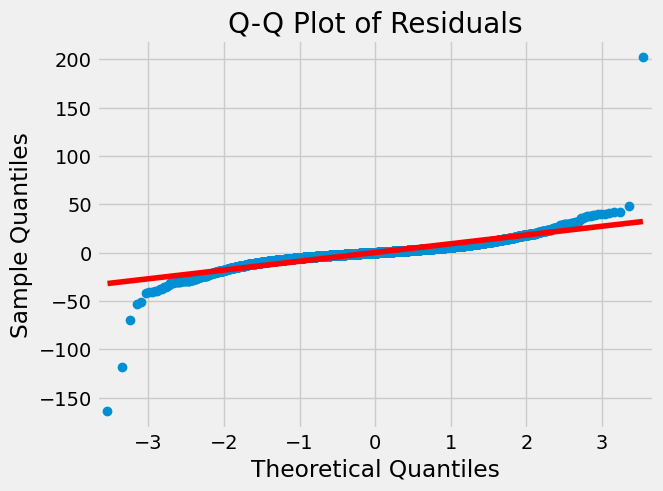

{'residuals': Date
 2002-01-03    202.000000
 2002-01-04      0.499503
 2002-01-07      0.983907
 2002-01-08      0.480036
 2002-01-09     -1.499933
                  ...    
 2021-12-27      8.833639
 2021-12-28    -10.188133
 2021-12-29      1.285605
 2021-12-30     -9.996775
 2021-12-31     -1.962702
 Length: 5034, dtype: float64,
 'lb_test':       lb_stat  lb_pvalue
 20  39.212047   0.006274,
 'lb_test_pvalues': 0.006273971913551123,
 'has_resid_autcorr': True,
 'stat_shapiro': 0.7971339821815491,
 'shapiro_pvalue': 0.0,
 'is_norm_resid': False}

In [27]:
train_commodity ,test_commodity  = train_test_split(commodity,date_column='Date',split='2022-01-01',by_date=True)


train_price = train_commodity.dropna()["Adj Close"]
test_price = test_commodity.dropna()["Adj Close"]

print("Tamanho treino: ",len(train_price))
print("Tamanho teste: ",len(test_price))

auto_arima_v1 = pm.auto_arima(y=train_price,
                        start_p=1,
                        start_q=1,
                        test='adf',  
                        max_p=10, 
                        max_d=9, 
                        max_q=10,
                        error_action='ignore',
                        information_criterion = 'aic', # criterio para selecionar melhor modelo
                        suppress_warnings=True,
                        maxiter=100, 
                        stepwise=True
                        )

print(auto_arima_v1.order )

arima_v1 = ARIMA(train_price,order=auto_arima_v1.order)
arima_v1_fit = arima_v1.fit()

check_arima_residuals(arima_fitted=arima_v1_fit)

In [28]:
print(arima_v1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 5034
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -17974.335
Date:                Sun, 14 May 2023   AIC                          35954.671
Time:                        15:33:52   BIC                          35974.242
Sample:                             0   HQIC                         35961.528
                               - 5034                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8385      0.038    -22.193      0.000      -0.913      -0.764
ma.L1          0.8756      0.034     25.873      0.000       0.809       0.942
sigma2        74.0478      0.363    204.068      0.0

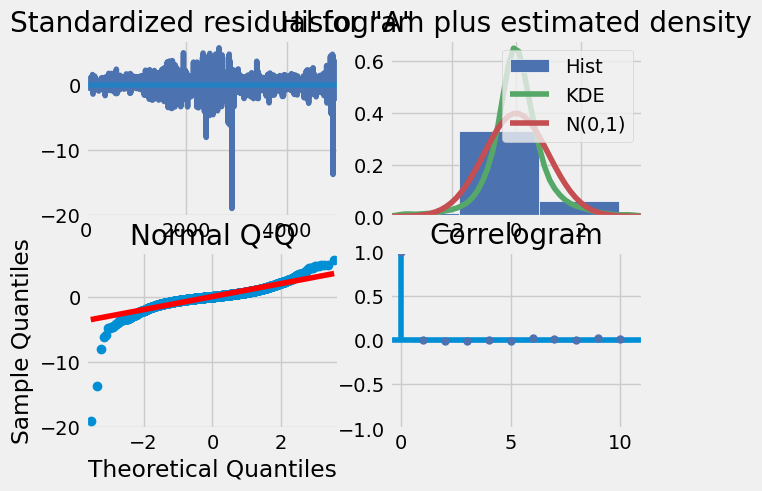

In [29]:
with plt.style.context("seaborn-deep"):
    arima_v1_fit.plot_diagnostics()

In [30]:
arima_V1_forecast = arima_v1_fit.forecast(len(test_price)).tolist()
comparative_v1 = test_price.reset_index().rename(columns={"Adj Close":"True_values"})
comparative_v1['ARIMA_V1'] = arima_V1_forecast
comparative_v1['Naive_last_train'] =train_price[-1]
kpis_v1 = get_kpis_summary(comparative_v1['True_values'],comparative_v1['ARIMA_V1'])

<AxesSubplot:xlabel='Date'>

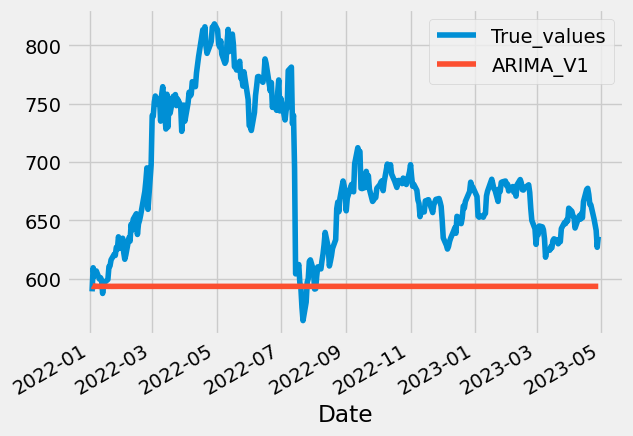

In [31]:
comparative_v1.set_index("Date")[['True_values',"ARIMA_V1"]].plot() # Resultados ruins

<AxesSubplot:xlabel='Date'>

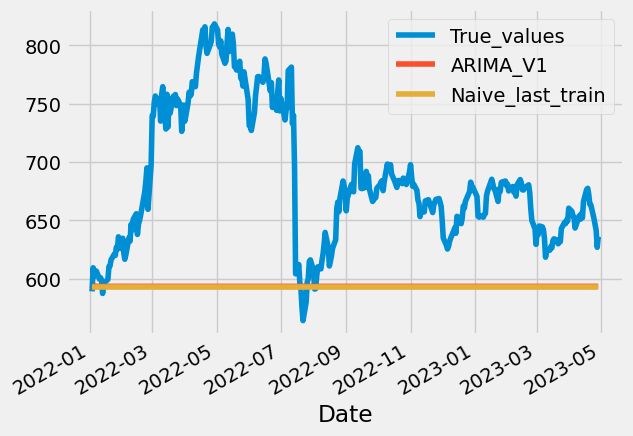

In [32]:
comparative_v1.set_index("Date").plot() # Resultados ruins

In [33]:
kpis_v1

,KPI,Result
0,MSE,11844.674881
1,RMSE,108.833243
2,MAE,91.914362
3,MASE,10.822109
4,OPE,0.128071
5,MAPE,0.128071
6,EVS,-0.000030
7,Max_err,224.680529
8,Rsquared,-2.402147


### ARIMA com transformação
- Dados mensais 
- Obs: método de transformação tirado do livro Modern Time Series Forecasting with Python

In [34]:
#month_commodity = commodity.copy().set_index("Date").asfreq("M",method='ffill')
month_commodity = month_commodity.reset_index()
month_commodity = month_commodity[['Date',"Adj Close"]]

train_commodity_monthly ,test_commodity_monthly  = train_test_split(month_commodity,date_column='Date',split='2022-01-01',by_date=True)

train_price_monthly = train_commodity_monthly.dropna()["Adj Close"]
test_price_monthly = test_commodity_monthly.dropna()["Adj Close"]

print("Tamanho treino: ",len(train_price_monthly))
print("Tamanho teste: ",len(test_price_monthly))


auto_stationary = AutoStationaryTransformer()
train_price_monthly_transformed =  auto_stationary.fit_transform(train_price_monthly, freq="1M")


auto_arima_v2 = pm.auto_arima(y=train_price_monthly_transformed ,
                        start_p=1,
                        start_q=1,
                        test='adf',  
                        max_p=10, 
                        max_d=9, 
                        max_q=10,
                        error_action='ignore',
                        information_criterion = 'aic', # criterio para selecionar melhor modelo
                        suppress_warnings=True,
                        maxiter=100, 
                        stepwise=True
                        )


print(auto_arima_v2.order)

arima_v2 = ARIMA(train_price_monthly_transformed ,order=auto_arima_v2.order)
arima_v2_fit = arima_v2.fit()

Train : start:2002-01-31 00:00:00 ---- end:2021-12-31 00:00:00
Test : start:2022-01-31 00:00:00 ---- end:2023-03-31 00:00:00
Tamanho treino:  240
Tamanho teste:  15
(0, 1, 1)


In [35]:
print(arima_v2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  240
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -173.954
Date:                Sun, 14 May 2023   AIC                            351.908
Time:                        15:35:47   BIC                            358.861
Sample:                    01-31-2002   HQIC                           354.709
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2105      0.026     -8.028      0.000      -0.262      -0.159
sigma2         0.2510      0.009     29.412      0.000       0.234       0.268
Ljung-Box (L1) (Q):                   0.00   Jarque-

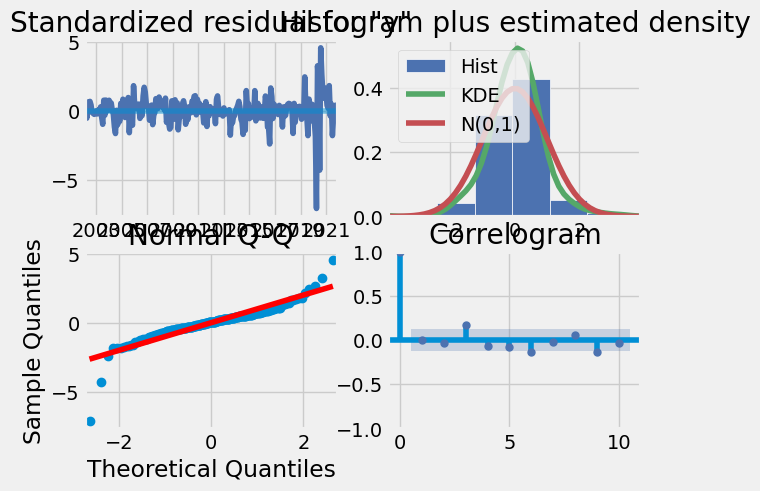

In [36]:

with plt.style.context("seaborn-deep"):
    arima_v2_fit.plot_diagnostics()

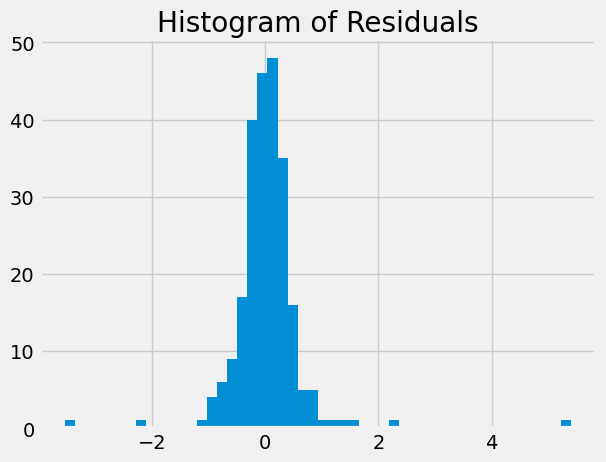

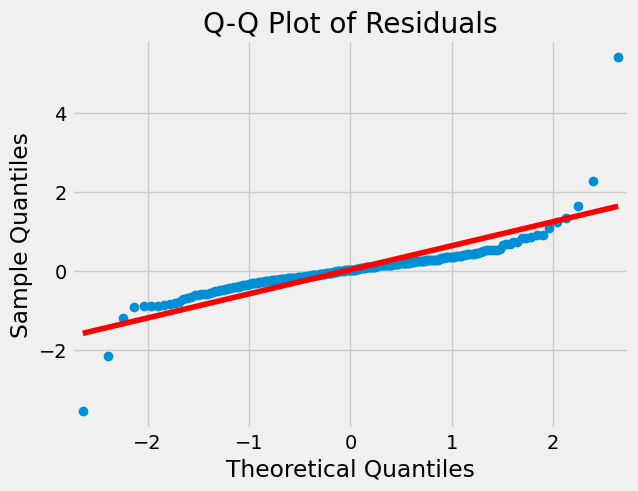

{'residuals': Date
 2002-01-31    5.400810
 2002-02-28   -0.136656
 2002-03-31    0.087629
 2002-04-30   -0.264321
 2002-05-31    0.320202
                 ...   
 2021-08-31   -0.290746
 2021-09-30   -0.046799
 2021-10-31    0.207373
 2021-11-30    0.029596
 2021-12-31    0.169323
 Length: 240, dtype: float64,
 'lb_test':       lb_stat  lb_pvalue
 20  11.423768   0.934484,
 'lb_test_pvalues': 0.9344841522708951,
 'has_resid_autcorr': False,
 'stat_shapiro': 0.7315472364425659,
 'shapiro_pvalue': 1.9750407955230232e-19,
 'is_norm_resid': False}

In [37]:
check_arima_residuals(arima_fitted=arima_v2_fit)

2022-01-31    588.348290
2022-02-28    589.196729
2022-03-31    590.045168
2022-04-30    590.893607
2022-05-31    591.742046
2022-06-30    592.590485
2022-07-31    593.438924
2022-08-31    594.287363
2022-09-30    595.135802
2022-10-31    595.984240
2022-11-30    596.832679
2022-12-31    597.681118
2023-01-31    598.529557
2023-02-28    599.377996
2023-03-31    600.226435
Freq: M, dtype: float64

In [38]:
arima_v2_forecast = arima_v2_fit.forecast(len(test_price_monthly))
arima_v2_forecast =auto_stationary.inverse_transform(arima_v2_forecast)
comparative_v2 = test_price_monthly.reset_index().rename(columns={"Adj Close":"True_values"})
comparative_v2['ARIMA_V2'] = arima_v2_forecast.tolist()
comparative_v2['Naive_last_train'] =train_price_monthly[-1]
comparative_v2

,Date,True_values,ARIMA_V2,Naive_last_train
0,2022-01-31,626.00,588.348290,593.25
1,2022-02-28,697.50,589.196729,593.25
2,2022-03-31,748.75,590.045168,593.25
3,2022-04-30,818.25,590.893607,593.25
4,2022-05-31,753.50,591.742046,593.25
5,2022-06-30,743.75,592.590485,593.25
6,2022-07-31,616.25,593.438924,593.25
7,2022-08-31,673.75,594.287363,593.25
8,2022-09-30,677.50,595.135802,593.25
9,2022-10-31,691.50,595.984240,593.25


<AxesSubplot:xlabel='Date'>

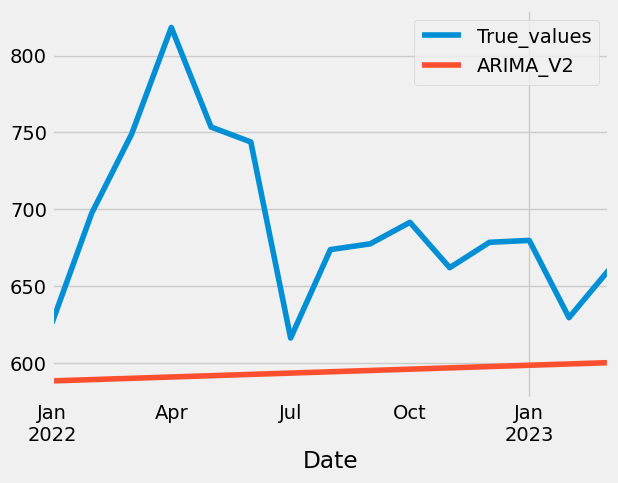

In [39]:
comparative_v2.set_index("Date")[['True_values',"ARIMA_V2"]].plot()

In [40]:
kpis_v2 = get_kpis_summary(comparative_v2['True_values'],comparative_v2['ARIMA_V2'])

In [41]:
kpis_v2

,KPI,Result
0,MSE,12246.498954
1,RMSE,110.663901
2,MAE,96.179304
3,MASE,2.251689
4,OPE,0.134264
5,MAPE,0.134264
6,EVS,-0.060336
7,Max_err,227.356393
8,Rsquared,-3.334189


### Arima Expanding Window (Mensal)

In [45]:
exp_arima_v1 = get_expanding_arima(train_price_monthly,test_price_monthly,print_flags=True)

2022-01-31 00:00:00 forecasted !!!!
Prediction:  590.9002331303011
---------------
2022-02-28 00:00:00 forecasted !!!!
Prediction:  624.9485348310743
---------------
2022-03-31 00:00:00 forecasted !!!!
Prediction:  694.6884171929491
---------------
2022-04-30 00:00:00 forecasted !!!!
Prediction:  753.8846181179065
---------------
2022-05-31 00:00:00 forecasted !!!!
Prediction:  820.4299180900404
---------------
2022-06-30 00:00:00 forecasted !!!!
Prediction:  769.6074511778683
---------------
2022-07-31 00:00:00 forecasted !!!!
Prediction:  735.4413957056569
---------------
2022-08-31 00:00:00 forecasted !!!!
Prediction:  637.4328119046893
---------------
2022-09-30 00:00:00 forecasted !!!!
Prediction:  650.2903138475135
---------------
2022-10-31 00:00:00 forecasted !!!!
Prediction:  697.6499180333286
---------------
2022-11-30 00:00:00 forecasted !!!!
Prediction:  672.6965586870934
---------------
2022-12-31 00:00:00 forecasted !!!!
Prediction:  680.9065969764185
---------------
2023

In [47]:
comparative_v3 = test_price_monthly.reset_index().rename(columns={"Adj Close":"True_values"})
comparative_v3['ARIMA_V3'] = exp_arima_v1['expand_forecasts']['Expanding_ARIMA_pred']
comparative_v3['Naive_last_value'] = comparative_v3['True_values'].shift(1)
comparative_v3

,Date,True_values,ARIMA_V3,Naive_last_value
0,2022-01-31,626.00,590.900233,NaN
1,2022-02-28,697.50,624.948535,626.00
2,2022-03-31,748.75,694.688417,697.50
3,2022-04-30,818.25,753.884618,748.75
4,2022-05-31,753.50,820.429918,818.25
5,2022-06-30,743.75,769.607451,753.50
6,2022-07-31,616.25,735.441396,743.75
7,2022-08-31,673.75,637.432812,616.25
8,2022-09-30,677.50,650.290314,673.75
9,2022-10-31,691.50,697.649918,677.50


<AxesSubplot:xlabel='Date'>

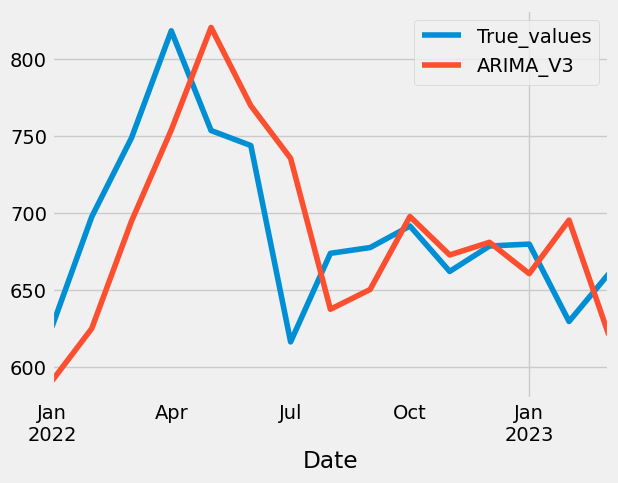

In [48]:
comparative_v3.set_index("Date")[['True_values',"ARIMA_V3"]].plot()

<AxesSubplot:xlabel='Date'>

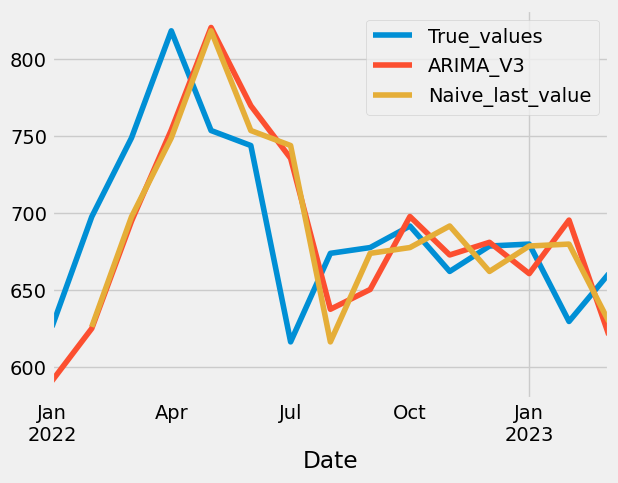

In [49]:
comparative_v3.set_index("Date").plot()

In [50]:
kpis_v3 = get_kpis_summary(comparative_v3['True_values'],comparative_v3['ARIMA_V3'])

### Arima Expanding Window com trasnformação (Mensal) 

In [51]:
test_price_monthly_transformed =  auto_stationary.transform(test_commodity_monthly)

In [52]:
test_price_monthly_transformed

Date
2022-01-31    7.406475
2022-02-28    7.760878
2022-03-31    7.977635
2022-04-30    8.237497
2022-05-31    7.989989
2022-06-30    7.946749
2022-07-31    7.322390
2022-08-31    7.624378
2022-09-30    7.638578
2022-10-31    7.701601
2022-11-30    7.552764
2022-12-31    7.631029
2023-01-31    7.632994
2023-02-28    7.364301
2023-03-31    7.527590
dtype: float64

In [60]:
exp_arima_v2 = get_expanding_arima(train_price_monthly_transformed,test_price_monthly_transformed,print_flags=True)
exp_arima_v2

2022-01-31 00:00:00 forecasted !!!!
Prediction:  7.184983116899034
---------------
2022-02-28 00:00:00 forecasted !!!!
Prediction:  7.3600136239601035
---------------
2022-03-31 00:00:00 forecasted !!!!
Prediction:  7.677463213817426
---------------
2022-04-30 00:00:00 forecasted !!!!
Prediction:  7.9159173706056185
---------------
2022-05-31 00:00:00 forecasted !!!!
Prediction:  8.171932042063496
---------------
2022-06-30 00:00:00 forecasted !!!!
Prediction:  8.02727890447471
---------------
2022-07-31 00:00:00 forecasted !!!!
Prediction:  7.963282347432218
---------------
2022-08-31 00:00:00 forecasted !!!!
Prediction:  7.453343656056843
---------------
2022-09-30 00:00:00 forecasted !!!!
Prediction:  7.589366522929495
---------------
2022-10-31 00:00:00 forecasted !!!!
Prediction:  7.628439276540925
---------------
2022-11-30 00:00:00 forecasted !!!!
Prediction:  7.6865320341017735
---------------
2022-12-31 00:00:00 forecasted !!!!
Prediction:  7.580337118092279
---------------
20

{'parameters': [(0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1)],
 'expand_forecasts':          Date  Expanding_ARIMA_pred
 0  2022-01-31              7.184983
 1  2022-02-28              7.360014
 2  2022-03-31              7.677463
 3  2022-04-30              7.915917
 4  2022-05-31              8.171932
 5  2022-06-30              8.027279
 6  2022-07-31              7.963282
 7  2022-08-31              7.453344
 8  2022-09-30              7.589367
 9  2022-10-31              7.628439
 10 2022-11-30              7.686532
 11 2022-12-31              7.580337
 12 2023-01-31              7.620577
 13 2023-02-28              7.630433
 14 2023-03-31              7.419206}

In [61]:
auto_stationary.inverse_transform(exp_arima_v2['expand_forecasts'].set_index("Date")["Expanding_ARIMA_pred"]).reset_index().rename(columns={0:"Expanding_ARIMA_pred"})

,Date,Expanding_ARIMA_pred
0,2022-01-31,588.348290
1,2022-02-28,618.563067
2,2022-03-31,680.470581
3,2022-04-30,734.644554
4,2022-05-31,800.874003
5,2022-06-30,763.687493
6,2022-07-31,748.621951
7,2022-08-31,640.515042
8,2022-09-30,667.539667
9,2022-10-31,676.274404


In [62]:
exp_arima_v2['expand_forecasts'] = auto_stationary.inverse_transform(exp_arima_v2['expand_forecasts'].set_index("Date")["Expanding_ARIMA_pred"]).reset_index().rename(columns={0:"Expanding_ARIMA_pred"})


In [63]:
exp_arima_v2['expand_forecasts']

,Date,Expanding_ARIMA_pred
0,2022-01-31,588.348290
1,2022-02-28,618.563067
2,2022-03-31,680.470581
3,2022-04-30,734.644554
4,2022-05-31,800.874003
5,2022-06-30,763.687493
6,2022-07-31,748.621951
7,2022-08-31,640.515042
8,2022-09-30,667.539667
9,2022-10-31,676.274404


In [64]:
comparative_v4 = test_price_monthly.reset_index().rename(columns={"Adj Close":"True_values"})
comparative_v4['ARIMA_V4'] = exp_arima_v2['expand_forecasts']['Expanding_ARIMA_pred']
comparative_v4['Naive_last_value'] = comparative_v4['True_values'].shift(1)

In [65]:
comparative_v4

,Date,True_values,ARIMA_V4,Naive_last_value
0,2022-01-31,626.00,588.348290,NaN
1,2022-02-28,697.50,618.563067,626.00
2,2022-03-31,748.75,680.470581,697.50
3,2022-04-30,818.25,734.644554,748.75
4,2022-05-31,753.50,800.874003,818.25
5,2022-06-30,743.75,763.687493,753.50
6,2022-07-31,616.25,748.621951,743.75
7,2022-08-31,673.75,640.515042,616.25
8,2022-09-30,677.50,667.539667,673.75
9,2022-10-31,691.50,676.274404,677.50


<AxesSubplot:xlabel='Date'>

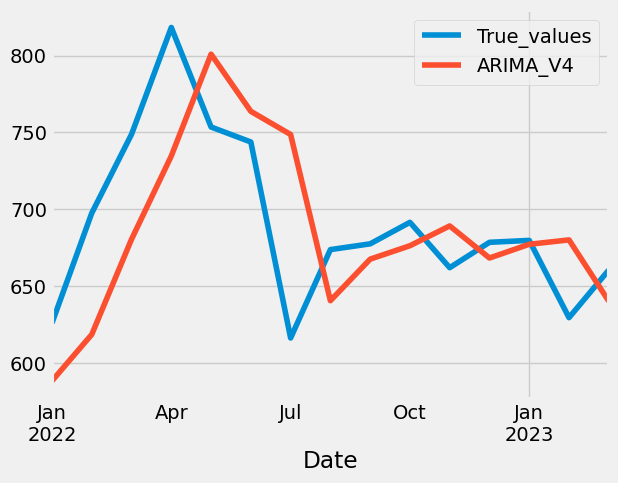

In [66]:
comparative_v4.set_index("Date")[['True_values','ARIMA_V4']].plot()

In [67]:
kpis_v4 = get_kpis_summary(comparative_v4['True_values'],comparative_v4['ARIMA_V4'])

In [68]:
kpis_v4

,KPI,Result
0,MSE,2981.294144
1,RMSE,54.601228
2,MAE,42.491623
3,MASE,0.994787
4,OPE,0.061875
5,MAPE,0.061875
6,EVS,-0.044403
7,Max_err,132.371951
8,Rsquared,-0.055117


-----

## Modelos ANN

In [123]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sb

In [91]:
def create_lags(df,target_variable='Adj Close',range_lags = [3,6,9,12,24]):
    df_modfic = df.copy()
    for i in range_lags:
        name_col = 'lag'+ str(i)
        df_modfic[name_col] = df_modfic[target_variable].shift(i)

    return df_modfic

def create_diffs(df,target_variable='Adj Close',range_diffs = [3,6,9,12,24]):
    df_modfic = df.copy()
    for i in range_diffs:
        name_col = 'diff'+ str(i)
        df_modfic[name_col] = df_modfic[target_variable].diff(i)

    return df_modfic


def create_rolling_op(df,target_variable='Adj Close',range_window = [3,6,9,12,24],op='mean'):
    df_modfic = df.copy()
    for i in range_window:
        name_col = op + "_" + str(i) 
        df_modfic[name_col] = df_modfic[target_variable].rolling(window=i).agg(op)

    return df_modfic



In [93]:
#criando variaveis 
month_commodity_ann = month_commodity.copy()

alvo = 1

month_commodity_ann['y_target'] = month_commodity_ann['Adj Close'].shift(-alvo) 

month_commodity_ann = create_lags(month_commodity_ann)
month_commodity_ann = create_diffs(month_commodity_ann)

month_commodity_ann = create_rolling_op(month_commodity_ann,op='mean')
month_commodity_ann = create_rolling_op(month_commodity_ann,op='std')

for i in [3,6,9,12,24]:
    name_dist = 'dist_mean_' + str(i)
    name_mean = "mean_" + str(i)
    month_commodity_ann[name_dist] = month_commodity_ann['Adj Close'] - month_commodity_ann[name_mean]


month_commodity_ann = month_commodity_ann.drop("Adj Close",axis=1)
month_commodity_ann = month_commodity_ann.dropna()
month_commodity_ann

,Date,y_target,lag3,lag6,lag9,lag12,lag24,diff3,diff6,diff9,...,std_3,std_6,std_9,std_12,std_24,dist_mean_3,dist_mean_6,dist_mean_9,dist_mean_12,dist_mean_24
24,2004-01-31,296.25,247.25,206.00,232.75,238.25,206.50,29.00,70.25,43.50,...,17.760560,18.614958,19.843310,17.098021,19.467477,20.500000,31.583333,37.722222,38.937500,42.593750
25,2004-02-29,320.00,245.00,233.25,244.25,231.75,200.00,51.25,63.00,52.00,...,25.298633,26.838716,27.723461,23.954058,21.984019,23.416667,41.083333,51.944444,53.562500,58.583333
26,2004-03-31,316.50,246.00,220.25,228.50,236.50,207.00,74.00,99.75,91.50,...,21.901769,31.392442,36.568951,32.571156,26.720880,22.500000,48.208333,65.527778,70.354167,77.625000
27,2004-04-30,304.00,276.25,247.25,206.00,232.75,193.50,40.25,69.25,110.50,...,12.821694,33.240663,36.809476,37.257321,28.664097,5.583333,33.166667,49.750000,59.875000,69.000000
28,2004-05-31,257.50,296.25,245.00,233.25,244.25,214.00,7.75,59.00,70.75,...,8.411302,27.936386,36.312255,39.384967,29.949232,-9.500000,10.833333,29.388889,42.395833,52.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2022-10-31,662.00,616.25,818.25,626.00,568.25,398.50,75.25,-126.75,65.50,...,9.355257,50.475592,58.953106,74.394704,99.457463,10.583333,-1.208333,-21.916667,7.583333,63.156250
250,2022-11-30,678.50,673.75,753.50,697.50,567.00,419.75,-11.75,-91.50,-35.50,...,14.756355,41.451000,61.292389,65.323699,89.123091,-15.000000,-15.458333,-47.472222,-29.833333,23.562500
251,2022-12-31,679.75,677.50,743.75,748.75,593.25,484.00,1.00,-65.25,-70.25,...,14.784564,26.411487,60.127209,57.834022,83.109431,1.166667,11.916667,-23.166667,-20.437500,31.958333
252,2023-01-31,629.50,691.50,616.25,818.25,626.00,547.00,-11.75,63.50,-138.50,...,9.906858,9.546814,41.351475,53.597864,80.575393,6.333333,2.583333,-6.527778,-23.666667,27.677083


In [135]:
corr = month_commodity_ann.query("Date <= '2022-01-01'").drop("Date",axis=1).corr()
target_corr = corr['y_target'].sort_values().reset_index()
target_corr['y_target'] = target_corr['y_target']
target_corr = target_corr.query("index != 'y_target' ")

In [163]:
significant_variables = target_corr[target_corr['y_target'].abs() >= 0.5]['index'].values.tolist()
filter_cols = ['Date','y_target'] + significant_variables

In [165]:
month_commodity_ann[filter_cols]

,Date,y_target,lag12,std_24,dist_mean_24,std_6,diff24,std_12,lag9,std_9,mean_24,lag6,mean_12,lag3,mean_9,mean_6,mean_3
24,2004-01-31,296.25,238.25,19.467477,42.593750,18.614958,69.75,17.098021,232.75,19.843310,233.656250,206.00,237.312500,247.25,238.527778,244.666667,255.750000
25,2004-02-29,320.00,231.75,21.984019,58.583333,26.838716,96.25,23.954058,244.25,27.723461,237.666667,233.25,242.687500,245.00,244.305556,255.166667,272.833333
26,2004-03-31,316.50,236.50,26.720880,77.625000,31.392442,113.00,32.571156,228.50,36.568951,242.375000,220.25,249.645833,246.00,254.472222,271.791667,297.500000
27,2004-04-30,304.00,232.75,28.664097,69.000000,33.240663,123.00,37.257321,206.00,36.809476,247.500000,247.25,256.625000,276.25,266.750000,283.333333,310.916667
28,2004-05-31,257.50,244.25,29.949232,52.750000,27.936386,90.00,39.384967,233.25,36.312255,251.250000,245.00,261.604167,296.25,274.611111,293.166667,313.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2022-10-31,662.00,568.25,99.457463,63.156250,50.475592,293.00,74.394704,626.00,58.953106,628.343750,818.25,683.916667,616.25,713.416667,692.708333,680.916667
250,2022-11-30,678.50,567.00,89.123091,23.562500,41.451000,242.25,65.323699,697.50,61.292389,638.437500,753.50,691.833333,673.75,709.472222,677.458333,677.000000
251,2022-12-31,679.75,593.25,83.109431,31.958333,26.411487,194.50,57.834022,748.75,60.127209,646.541667,743.75,698.937500,677.50,701.666667,666.583333,677.333333
252,2023-01-31,629.50,626.00,80.575393,27.677083,9.546814,132.75,53.597864,818.25,41.351475,652.072917,616.25,703.416667,691.50,686.277778,677.166667,673.416667


In [166]:
train_ANN ,test_ANN = train_test_split(month_commodity_ann,date_column='Date',split='2022-01-01',by_date=True)

Train : start:2004-01-31 00:00:00 ---- end:2021-12-31 00:00:00
Test : start:2022-01-31 00:00:00 ---- end:2023-02-28 00:00:00


In [167]:
X_train_ANN = train_ANN.drop("y_target",axis=1)
y_train_ANN = train_ANN['y_target']

X_test_ANN = test_ANN.drop("y_target",axis=1)
y_test_ANN = test_ANN['y_target']

In [168]:
x_mms = MinMaxScaler()

X_train_norm = x_mms.fit_transform(X_train_ANN)
X_test_norm = x_mms.transform(X_test_ANN)

y_mms = MinMaxScaler()

y_train_norm = y_mms.fit_transform(y_train_ANN.values.reshape(-1,1))
y_test_norm = y_mms.transform(y_test_ANN.values.reshape(-1,1))


In [187]:
mlp_v1 = MLPRegressor(hidden_layer_sizes = (100,500,100),  # camadas ajudam a capturar nao linearidade de dados financeiros 
                    max_iter = 500,
                    solver = "lbfgs", 
                    verbose = 10, 
                    tol = 1e-8, 
                    random_state = 42,
                    activation = "tanh")

mlp_v1.fit(X_train_norm, y_train_ANN ) # essa é a linha que treina o modelo!!!!

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       103301     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01011D+05    |proj g|=  4.24576D+02

At iterate    1    f=  9.80193D+04    |proj g|=  4.17715D+02

At iterate    2    f=  9.26916D+04    |proj g|=  4.04562D+02

At iterate    3    f=  8.11451D+04    |proj g|=  3.74903D+02

At iterate    4    f=  1.60380D+04    |proj g|=  6.55843D+03

At iterate    5    f=  1.06315D+04    |proj g|=  3.16039D+03

At iterate    6    f=  7.54519D+03    |proj g|=  6.79167D+03

At iterate    7    f=  6.35244D+03    |proj g|=  2.62708D+03

At iterate    8    f=  5.70901D+03    |proj g|=  1.45304D+03

At iterate    9    f=  5.16727D+03    |proj g|=  9.61162D+02

At iterate   10    f=  4.84821D+03    |proj g|=  8.56390D+02

At iterate   11    f=  4.34232D+03    |proj g|=  9.06901D+02



 This problem is unconstrained.


At iterate   12    f=  4.13410D+03    |proj g|=  4.12554D+02

At iterate   13    f=  3.66842D+03    |proj g|=  1.07918D+03

At iterate   14    f=  3.36791D+03    |proj g|=  5.24290D+02

At iterate   15    f=  3.10471D+03    |proj g|=  4.90240D+02

At iterate   16    f=  2.45539D+03    |proj g|=  6.26593D+02

At iterate   17    f=  2.32903D+03    |proj g|=  1.70743D+03

At iterate   18    f=  1.86146D+03    |proj g|=  5.71096D+02

At iterate   19    f=  1.63767D+03    |proj g|=  6.75293D+02

At iterate   20    f=  1.44606D+03    |proj g|=  3.82748D+02

At iterate   21    f=  1.37247D+03    |proj g|=  9.50307D+02

At iterate   22    f=  1.30263D+03    |proj g|=  4.74310D+02

At iterate   23    f=  1.26432D+03    |proj g|=  1.28939D+02

At iterate   24    f=  1.23734D+03    |proj g|=  1.31998D+02

At iterate   25    f=  1.20404D+03    |proj g|=  1.41078D+02

At iterate   26    f=  1.15614D+03    |proj g|=  1.01954D+02

At iterate   27    f=  1.09616D+03    |proj g|=  5.37055D+02

At itera

MLPRegressor(activation='tanh', hidden_layer_sizes=(100, 500, 100),
             max_iter=500, random_state=42, solver='lbfgs', tol=1e-08,
             verbose=10)

In [188]:
y_pred_train1 = mlp_v1.predict(X_train_norm)
y_pred_test1 = mlp_v1.predict(X_test_norm)

In [192]:
y_pred_test1 

array([695.7562258 , 674.91384817, 695.75750796, 674.90965917,
       695.75784652, 695.75784652, 695.75784593, 695.75784652,
       695.75784652, 695.75784649, 695.75784652, 695.75784652,
       695.75784652, 695.75784652])

In [190]:
y_test_ANN

Date
2022-01-31    697.50
2022-02-28    748.75
2022-03-31    818.25
2022-04-30    753.50
2022-05-31    743.75
2022-06-30    616.25
2022-07-31    673.75
2022-08-31    677.50
2022-09-30    691.50
2022-10-31    662.00
2022-11-30    678.50
2022-12-31    679.75
2023-01-31    629.50
2023-02-28    660.50
Name: y_target, dtype: float64

In [194]:
comparative_v5 = y_test_ANN.reset_index()
comparative_v5

,Date,y_target
0,2022-01-31,697.50
1,2022-02-28,748.75
2,2022-03-31,818.25
3,2022-04-30,753.50
4,2022-05-31,743.75
5,2022-06-30,616.25
6,2022-07-31,673.75
7,2022-08-31,677.50
8,2022-09-30,691.50
9,2022-10-31,662.00


In [195]:
comparative_v5['ANN_v1'] = y_pred_test1 

<AxesSubplot:xlabel='Date'>

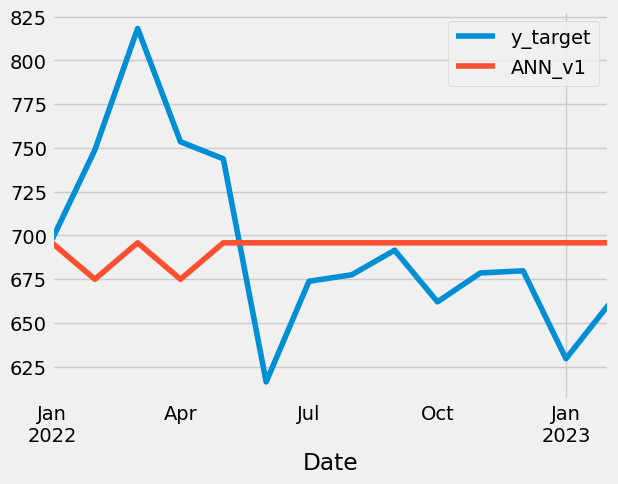

In [197]:
comparative_v5.set_index("Date").plot()